In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.linalg import norm

In [4]:
#!mkdir ./utils
#!curl -o ./utils/simplex_projection.py https://gist.githubusercontent.com/daien/1272551/raw/df474b9c7600cc66d27b6df88d5266d7cb6d9e95/simplex_projection.py

Robust PCA:

Data matrix = Low-rank matrix + Sparse matrix

<img src="http://kojinoshiba.com/assets/images/2018-05-27-robust-pca/robust_pca.png" width=600>

https://statweb.stanford.edu/~candes/math301/Lectures/rpca.pdf

Альтернативная формулировка RPCA:

\begin{gather}
\min_{\mathbf{L}, \mathbf{E}}  \lVert \mathbf{X} - \mathbf{L} - \mathbf{E}\rVert_F^2 \\
s.t. \mathrm{rank}(\mathbf{L}) \leq k, \mathrm{card}(\mathbf{E}) \leq r
\end{gather}

После [релаксации](https://www.idi.ntnu.no/~schellew/convexrelaxation/ConvexRelaxation.html):

\begin{gather}
\min_{\mathbf{L}, \mathbf{E}}  \lVert \mathbf{X} - \mathbf{L} - \mathbf{E}\rVert_F^2 \\
s.t.  \lVert \mathrm{vec} (\mathbf{E}) \rVert_1 \leq \lambda,  \lVert \mathbf{L} \rVert_* \leq \gamma
\end{gather}

<imp src="https://tianyizhou.files.wordpress.com/2011/04/background.jpg">

<imp src="https://raw.githubusercontent.com/dfm/pcp/master/demo.png">

<imp src="https://ars.els-cdn.com/content/image/1-s2.0-S1047320314001989-gr1.jpg">


In [5]:
import sys
sys.path.append('./')

from utils.simplex_projection import euclidean_proj_simplex

def euclidean_proj_l1_ball(v, s=1):
    u = np.abs(v)
    if u.sum() <= s:
        return v
    w = euclidean_proj_simplex(u, s=s)
    w *= np.sign(v)
    return w

In [358]:
from scipy.sparse.linalg import svds

def nuclear_lmo(grad, gamma, shape=None):
    if not shape==None:
        u,s,vt = svds(grad.reshape(shape), k=1)
        return -gamma*np.outer(u,vt).flatten()
    else:
        u,s,vt = svds(grad, k=1)
        return -gamma*np.outer(u,vt)

In [359]:
def l1_lmo(grad, gamma):
    idx = np.argmax(np.abs(grad))
    x = np.zeros(grad.shape)
    x[idx] = -gamma*np.sign(grad[idx])
    return x

In [525]:
from scipy.optimize import line_search, minimize_scalar


def robustPCA(Y, lmbda, gamma, max_iter=500):
    """
    Robust PCA via Frank-Wolfe and projected gradient [http://www.columbia.edu/~jw2966/papers/MZWG14-pp.pdf]
    
    Parameters
    -------
    Y : ndarray, shape (M,N)
        Data matrix (of the size M x N) to be decomposed
    lmbda : float > 0
        Radius of the L1 norm ball
    gamma : float > 0
        Radius of the nuclear norm ball
    max_iter : int
        Maximum number of iterations  
    
    Returns
    -------
    L : ndarray, shape (M,N)
        Low-rank matrix
    S : ndarray, shape (M,N)
        Sparse matrix
    """
    
    M,N = Y.shape
    # initial solution
    L = Y.copy()
    S = np.random.randn(M,N)
    L = nuclear_lmo(L, gamma)
    S = l1_lmo(S.flatten(), lmbda).reshape(S.shape)    
    k = 0
    d = np.inf
    while d > 1e-4 and k < max_iter:
        # gradient
        grad = L + S - Y
        # LMO
        V_L = nuclear_lmo(grad, gamma)
        V_S = l1_lmo(grad.flatten(), lmbda).reshape(S.shape)
        d = np.sum(grad*(L - V_L)) + np.sum(grad*(S - V_S))
        #stepsize
        alpha = 2./(k+2.) #standard stepsize
        #alpha = minimize_scalar(lambda a: func(x + a*(s - x)), bounds=(0, 1)).x 
        # update solution
        L = L + alpha*(V_L - L)
        S = S + alpha*(V_S - S)
        # update S with projected gradient
        S = euclidean_proj_l1_ball((Y - L).flatten(), lmbda).reshape(S.shape)
        k = k + 1
        
        f = norm(Y - L - S, 'fro')**2
        print(f, d)

    return L, S

Video Background Subtraction

<img src="https://res.mdpi.com/applsci/applsci-07-00989/article_deploy/html/images/applsci-07-00989-g008.png" width=800>

Frame = Background + Foreground

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/009251d955e3a0967f7f43143a03e7cced951207/9-Figure10-1.png">

In [484]:
from scipy.io import loadmat

mat = loadmat('mall.mat')

D = mat['D']
frameSize = mat['frameSize']

Y = D.T
height = frameSize[0][0]
width = frameSize[0][1]

print(Y.shape)
print(height, width)

(300, 81920)
256 320


In [485]:
M,N = Y.shape
print(M,N)

300 81920


In [486]:
m = np.mean(Y.flatten());
scale = norm(Y, 'fro');

In [513]:
delta = 0.5
gamma = delta; 
lmbda = delta*np.sqrt(np.maximum(M,N))

In [514]:
X = Y.copy()
X = (X - m)/scale

In [515]:
L, S = robustPCA(X, lmbda, gamma, max_iter=50)

0.0761370424870044 41032.01639254804
0.006457101457681032 0.12538851791063352
0.07348706596834732 0.039747777545688
0.010996833239220063 0.14429569631377917
0.002636650312842727 0.025441648056958085
0.008485255383295049 0.012922876226719796
0.006683122540018633 0.033066672158066454
0.004105159204402374 0.023811294271305256
0.004101025269660648 0.01651939645091856
0.0030909051095418753 0.01886971077780303
0.002933318648156891 0.013668530781457107
0.002492983161722772 0.014449000603913494
0.002412483400258099 0.011771634427437394
0.0020752640646774976 0.012095953132089497
0.002020146025983516 0.00989138915038323
0.0018447774672805757 0.010287683585635924
0.0017881695655061127 0.008874468875382726
0.0016586192998693863 0.008928195844739978
0.001626795477303557 0.00787366699057346
0.0015439519261872987 0.007987070705024127
0.0015042778064025355 0.00718041891737115
0.0014452966879941584 0.007114375519654791
0.001419227088018375 0.006558911085055937
0.0013752001831090308 0.006507368257064245

In [516]:
X_ = X.flatten()
L_ = L.flatten()
S_ = S.flatten()

S_ = X_ - L_

max_val = np.max(np.abs(S_))
idx = S_ < 0.5*max_val

# then obtain the difference between X and L at those tentatively
# identified background locations
differ = X_[idx] - L_[idx]

# we set the threshold at the mean of the difference values plus
# three standard deviations of those difference values and apply it to S
mu = np.mean(differ)
sigma = np.std(differ)

In [517]:
t = 2

threshold_upper = mu + t*sigma
threshold_lower = mu - t*sigma

Smask_ = np.logical_or(S_ > threshold_upper, S_ < threshold_lower)

L_result = L*scale + m
S_result = Smask.reshape(Y.shape)*255

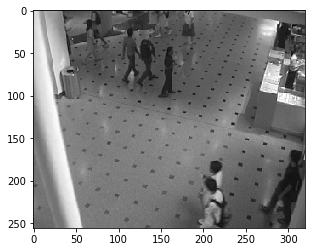

In [519]:
plt.imshow(Y[50,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.show()

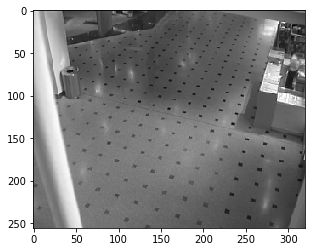

In [520]:
plt.imshow(L_result[50,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.show()

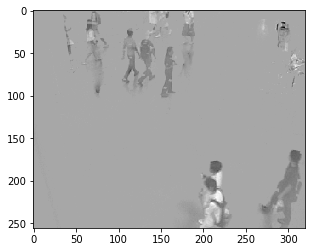

In [521]:
plt.imshow(S[50,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.show()

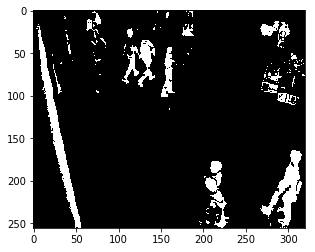

In [522]:
plt.imshow(S_result[50,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.show()

In [526]:
from matplotlib import animation, rc
from IPython.display import HTML

from scipy import ndimage


plt.close('all')
fig = plt.figure(figsize=(15,15))

im = plt.imshow(np.random.rand(height, 3*width)*255, animated=True, cmap=plt.cm.gray)

i = 0
def updatefig(*args):
    global X, L, S, width, height, i 
    i = i + 1
    frame1 = np.reshape(Y[i,:], [width, height]).T
    frame2 = np.reshape(L_result[i,:], [width, height]).T
    frame3 = np.reshape(np.abs(S_result[i,:]), [width, height]).T
    #frame3 = ndimage.median_filter(frame3, 3)
    frame = np.c_[frame1, frame2, frame3]   
    im.set_array(frame)
    return im,

#rc('animation', html='html5')
anim = animation.FuncAnimation(fig, updatefig, interval=100, blit=True)

In [527]:
HTML(anim.to_html5_video())